
![Translation](trans.png)

# Calling C++ code from Python

## Problem

 - We have some existing C++ code which operates on array/image data
 - We want to call it from Python
 - We want to use Numpy arrays to pass input and receive output
 - **Ideally, want to avoid too much copying of large data**
 

## Solution I will present

 - Build a **Cython** extension
 

## Alternative solutions I will mention briefly

 - Create a pure-C API and use `ctypes`
 - Wrapper-generators (e.g. `swig`)
 - Wrapping a command line tool


# Sample C++ code
    #include "newimage/newimageall.h"

    void process_volume(NEWIMAGE::volume4D<float> &invol)
    {
        // Do some clever stuff
        invol.binarise(0.5);
    }

    int main(int argc, char **argv)
    {
        char *input_file = argv[1];
        char *output_file = argv[2];

        NEWIMAGE::volume4D<float> invol;
        read_volume4D(invol, input_file);

        process_volume(invol);
        save_volume4D(invol, output_file);
    }


    
## First provide an entry point using C++ native types

    #include <vector>
    #include <iostream>
    
    std::vector<float> process_vectors(std::vector<float> &input, int nx, int ny, int nz, int nt)
    {
        // This is just so we can see if the data has been copied
        std::cerr << "In C++ the input vector starts at address " << &input[0] << std::endl;
        
        // Here we ought to check that nx, ny, nz, nt is consistent with overall length of input
        
        // Create a volume4D using an existing data buffer
        // when we do this, NEWIMAGE will not try to delete the data buffer
        NEWIMAGE::volume4D<float> invol(nx, ny, nz, nt, &input[0]);

        // Do our processing step
        process_volume(invol);
        
        // Input data has been modified, so return it directly
        return input;
    }



# Array ordering

![Ordering](abc.png)

If `input` is a 4D image, it's pretty clear that the first element is the voxel with co-ordinates `(0, 0, 0, 0)`

But what is the next element?

Is it voxel `(1, 0, 0, 0)`?

Or `(0, 0, 0, 1)`?

If the *first* axis is the one which varies fastest, we are using **Column-Major** ordering
If the *last* axis is the one which varies fastest, we are using **Row-Major** ordering

## So, which is the standard?

| Row-major            | Column-major | 
| ------------         | ---------    | 
| C/C++ native arrays  | Fortran      | 
| Python/Numpy default | Matlab       |
| SAS                  | FSL NEWIMAGE | 



### Here, we will need to make sure our Numpy arrays are passed as 1-dimensional float arrays in Column-major order to match NEWIMAGE

    data.flatten(order='F').astype(np.float32)
    
 - `'F'` stands for 'Fortran order'
 - A C++ `float` is *almost* guaranteed to be 32 bits
 


![Cython](cython.png)

# Cython extension

## First, the Cython wrapper


In [ ]:
# my_analysis_wrapper.pyx

import numpy as np
cimport numpy as np

from libcpp.vector cimport vector

cdef extern from "my_analysis.h":
    vector[float] process_vector(vector[float] &, int, int, int, int)
    
def process_using_vectors(data):
    # Save the dimensions of the data because we're going to flatten it to 1D array
    # Should be checking the dimensions at this point!
    nx, ny, nz, nt = data.shape

    # Convert data to 1D in Column-major (Fortran) order
    # This always copies the data
    data = data.flatten(order='F').astype(np.float32)

    # This line is just so we can see if the data is being copied
    print("In python the input data starts at %X" % data.__array_interface__['data'][0])

    # Call the C++ code
    output = process_vectors(data, nx, ny, nz, nt)

    # Output is a 1D array in Fortran order - turn it back into a multidimensional array
    # This should not copy the data
    output = np.reshape(output, [nx, ny, nz, nt], order='F')
    print("In python the reshaped data starts at %X" % output.__array_interface__['data'][0])
    
    return output
    

        
## Next, build the extension

This would normally go in `setup.py`


In [ ]:
import os
import sys
import numpy

from setuptools import setup
from Cython.Build import cythonize
from setuptools.extension import Extension

# My Cython extension
fsldir = os.environ["FSLDIR"]

ext = Extension("my_analysis_wrapper",
                 sources=['my_analysis_wrapper.pyx',
                          'my_analysis.cpp'],
                 language="c++",
                 include_dirs=[".", numpy.get_include(), 
                               os.path.join(fsldir, "include"), 
                               os.path.join(fsldir, "extras/include"), 
                               os.path.join(fsldir, "extras/include/newmat")], 
                 libraries=['newimage', 'miscmaths', 'fslio', 'niftiio', 'newmat', 'znz', "zlib"],
                 library_dirs=[os.path.join(fsldir, "lib"), os.path.join(fsldir, "extras/lib")])

# setup parameters
setup(name='my_app',
      description='My Python application which calls C++',
      ext_modules=cythonize(ext))

In [1]:
%run setup.py build_ext

running build_ext
copying build\lib.win-amd64-2.7\my_analysis_wrapper.pyd -> 


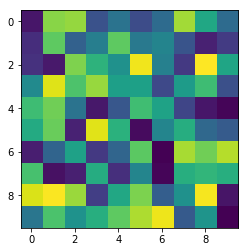

In python the input data starts at A55A980
In C++ the input vector starts at address 000000000A87D5A0

In python the reshaped data starts at A6B2040


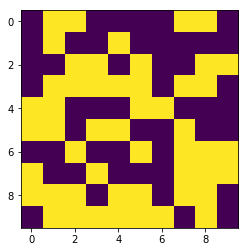

In [2]:
import numpy
import my_analysis_wrapper
import matplotlib.pyplot as plt

data = numpy.random.rand(10, 10, 10, 10)

plt.imshow(data[:,:,5,5])
plt.show()

output = my_analysis_wrapper.process_with_vectors(data)
plt.imshow(output[:,:,5,5])
plt.show()


# Great, it worked

## But we did copy our data  - several times

 - We copied the input once in Python to flatten it in the right order
 - Cython copied it again, because the pointer to the memory in the `vector` is different from the pointer to the data in the Numpy array.
 - Similarly, converting the output `vector` back to a Numpy array would involve a copy
 

## Do we care?

It depends on:

 - Is the processing time per-voxel much greater than the data copying time?
   - If so, copying will not add significant overhead
 - Might the data be comparable in size to system memory?
   - If so, copying may result in swapping and significant slowness
   



# Solution with less copying

We can't use a `vector`, it needs to be free to manage its own memory, not use an existing fixed buffer.

Instead pass a pure C array:


    void process_array(float *input, int nx, int ny, int nz, int nt)
    {
        cerr << "In C++ the input array starts at address " << input << std::endl;

        NEWIMAGE::volume4D<float> invol(nx, ny, nz, nt, input);

        process_volume(invol);
        
        // Volume data buffer is modified directly, so provided it was not copied
        // we should be able to see the output directly in Python   
    }


 - Note that we cannot check the size of the `input` buffer! It had better be correct

In [ ]:
# my_analysis_wrapper.pyx

import numpy as np
cimport numpy as np

from libcpp.vector cimport vector

cdef extern from "my_analysis.h":
    void process_array(float *, int, int, int, int)

def process_c(np.ndarray[np.float32_t, ndim=1] input,
              nx, ny, nz, nt):
    process_array(&input[0], nx, ny, nz, nt)

def process_with_arrays(data):
    # Save the dimension of the data because we're going to flatten it to 1D array
    nx, ny, nz, nt = data.shape

    # Convert data to 1D in Column-major (Fortran) order
    data = data.flatten(order='F').astype(np.float32)

    print("In python the data starts at %X" % data.__array_interface__['data'][0])

    process_c(data, nx, ny, nz, nt)

    data = np.reshape(data, [nx, ny, nz, nt], order='F')
    print("In python the reshaped data starts at %X" % data.__array_interface__['data'][0])
    
    return data


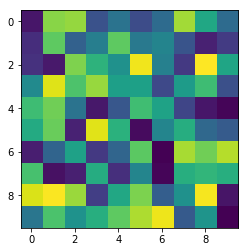

In python the data starts at A870040
In C++ the input array starts at address 000000000A870040

In python the reshaped data starts at A870040


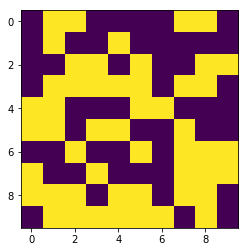

In [3]:
import numpy
import my_analysis_wrapper

plt.imshow(data[:,:,5,5])
plt.show()

output = my_analysis_wrapper.process_with_arrays(data)
plt.imshow(output[:,:,5,5])
plt.show()


 - We copied our input data once when we flattened it into Fortran order
 - C++ code operated directly on that buffer
 - Output data was not copied when reshaped 

# Summary

 - Easy-ish recipe for passing Numpy arrays to C++ either as a `std::vector` or as a `float *` array.
 - Can construct `NEWIMAGE::volume<float>` or other complex containers from within C++
 - Easy modification to instead use `double` array
 - Can pass Python strings to `C++ std::string` and other C++ containers in a similar way



# Alternatives (Briefly!)

## Why?

![Compatibility](cython_compat1.png)

## Can we assume that our newly compiled Cython/C++ code will link correctly with `libnewimage.a`?

 - Often, yes, but in general, no
 - It depends on the compiler used for each - ideally they need to match
 - The compiler of your Cython extension is **fixed** by the version of Python you are using
 - Might need to recompile your dependency libraries with this compiler
 - If you can't do this (e.g. commercial binary) you may be **stuck**

## Three common problem scenarios

 - On Mac, need to use the same C++ standard library (either `libc++` or `libstdc++`)
 - On Python 2, C++ compiler will be very old (may not support all of C++11)
 - On Windows, no two versions of VC++ are binary compatible
 

# Alternative approach where this is a problem

 - Make your code a shared library with a *Pure C* API
 - Use `ctypes`
 
## `ctypes`

 - Part of Python standard library
 - Allows you to call library functions from 'C' shared library (not C++)
 - **Pure 'C' libraries are (generally) binary compatible on a given platform**
 - We have to load the library manually
 - We have to tell Python about the input and return types
 

# Pure 'C' API for our processing function

    // my_analysis_purec.h

    #ifdef __cplusplus
    extern "C" {
    #endif
    
    void process_array(float *input, int nx, int ny, int nz, int nt);
    
    #ifdef __cplusplus
    }
    #endif
    


 - Note need to use `extern "C" { }` if we may want to include this header from C++
 - **On Windows, additional code is required to make the shared library (DLL) link correctly!**
 - Note that the implementation *can* use C++

In [ ]:
import ctypes import CDLL, c_int, c_char_p
import numpy as np
import numpy.ctypeslib

def process_ctypes(data):
    
    clib = ctypes.cdll.LoadLibrary("libmy_analysis.so")

    # This is the data type of a 1-D Numpy array
    c_float_arr = numpy.ctypeslib.ndpointer(dtype=np.float32, ndim=1, flags='CONTIGUOUS')

    # This specifies the argument types for the 'process_array' function
    # This is not actually required but enables ctypes to do some error checking
    clib.process_array.argtypes = [c_float_arr, c_int, c_int, c_int, c_int]

    # Put the Numpy data into row-major order and make sure it is contiguous in memory
    item = np.ascontiguousarray(item.flatten(order='F'), dtype=np.float32)
    
    clib.process_carray(data, shape[0], shape[1], shape[2], shape[3])


# Comparison with Cython

## Cython advantages

 - Python wrapper is probably a little quicker and cleaner to write
 - Don't need to produce a new pure-C API provided we have an entry point using C++ types
 - Potential for better error-checking
 - Might integrate well if you are already using Cython
 - No need to build a shared library
 
## `ctypes` advantages

 - Part of the Python standard library
 - No additional compile step in `setup.py`
 - Binary compatibility - no need to be tied to a single (perhaps old) C++ compiler
 
## Conclusion?

 - Use Cython when you can, `ctypes` if you have to
 

# Other alternatives (briefly for completeness)

## Wrapper Generators (SWIG, shiboken, others)

 - Run a preprocessor on your C++ code to generate an 'automatic' Python wrapper
 - Generally need to write an 'interface specifier' for each C++ header to describe how it interfaces to Python
 - Great when you have a large, complex C++ API which needs to be consistently exposed to Python (e.g. wx/wxpython, QT/PyQT)
 - SWIG can support other languages as well as Python
 - Probably more work than Cython/ctypes if you have a single simple API


## Just Wrap the Command Line

 - Quick and dirty
 - Copies all data to/from filesystem
 - Need to go via command line API, create temp directories, etc
 - Don't overlook as a way of getting started - can move to other solution later
 


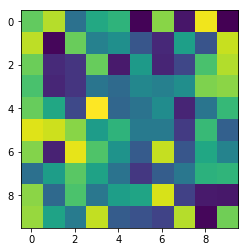

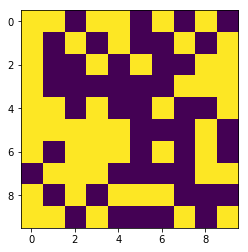

In [4]:
import os
import tempfile
import subprocess
import tempfile
import shutil

import numpy as np
import nibabel as nib
os.environ["FSLOUTPUTTYPE"] = "NIFTI_GZ"

def binarise(data):
    # Remember the directory where we started
    cwd_orig = os.getcwd()
    try:
        # Create a temporary directory
        tempdir = tempfile.mkdtemp("fsl")
        
        # Save input data in temp directory
        os.chdir(tempdir)
        tmpin = nib.Nifti1Image(data, np.identity(4))
        tmpin.to_filename("in.nii.gz")
        
        # Run a command from $FSLDIR
        fslmaths = os.path.join(os.environ["FSLDIR"], "bin", "fslmaths")
        
        # We could use os.system here if we don't care about returning the stdout/stderr
        p = subprocess.Popen([fslmaths, "in.nii.gz", "-thr", "0.5", "-bin", "out.nii.gz"], 
                             stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
        cmd_stdout = ""
        while 1:
            retcode = p.poll()
            cmd_stdout += p.stdout.readline()
            if retcode is not None: break
        if retcode != 0:
            raise RuntimeError("Error: %s" % cmd_stdout)
        
        # Load the output file and return it with the command standard output
        out_nii = nib.load("out.nii.gz")
        return out_nii.get_data(), cmd_stdout
    finally:
        # Change back to our starting directory
        os.chdir(cwd_orig)

data = np.random.rand(10, 10, 10, 10)
plt.imshow(data[:,:,5,5])
plt.show()

output, stdout = binarise(data)
plt.imshow(output[:,:,5,5])
plt.show()



# Summary

## What we've done

 - It's not that hard to call existing C++ code from Python
 - Need to be a bit careful with Numpy arrays
 - Cython is probably the easiest method
 - Data copying can be minimised by passing data as C arrays (`float *` etc)
 - `ctypes` may be a good alternative if you have binary compatibility issues
 - Can always wrap a command line tool as a way of getting started!
 
 
 